In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [235]:
df_dict = {}

In [236]:
top25_14 = ['Alabama', 'Oregon', 'Florida St.', 'Ohio St.', 'Baylor',
            'TCU', 'Mississippi St.', 'Michigan St.', 'Ole Miss', 'Arizona',
            'Kansas St.', 'Georgia Tech', 'Georgia', 'UCLA', 'Arizona St.',
            'Missouri', 'Clemson', 'Wisconsin', 'Auburn', 'Boise St.',
            'Louisville', 'Utah', 'LSU', 'Southern California', 'Minnesota']

top25_15 = ['Clemson', 'Alabama', 'Michigan St.', 'Oklahoma', 'Iowa',
            'Stanford', 'Ohio St.', 'Notre Dame', 'Florida St.', 'North Carolina',
            'TCU', 'Ole Miss', 'Northwestern', 'Michigan', 'Oregon',
            'Oklahoma St.', 'Baylor', 'Houston', 'Florida', 'LSU',
            'Navy', 'Utah', 'Tennessee', 'Temple', 'Southern California']

top25_16 = ['Alabama', 'Clemson', 'Ohio St.', 'Washington', 'Penn St.',
            'Michigan', 'Oklahoma', 'Wisconsin', 'Southern California', 'Colorado',
            'Florida St.', 'Oklahoma St.', 'Louisville', 'Auburn', 'Western Mich.',
            'West Virginia', 'Florida', 'Stanford', 'Utah', 'LSU',
            'Tennessee', 'Virginia Tech', 'Pittsburgh', 'Temple', 'Navy']

top25_17 = ['Clemson', 'Oklahoma', 'Georgia', 'Alabama', 'Ohio St.',
            'Wisconsin', 'Auburn', 'Southern California', 'Penn St.', 'Miami FL',
            'Washington', 'UCF', 'Stanford', 'Notre Dame', 'TCU',
            'Michigan St.', 'LSU', 'Washington St.', 'Oklahoma St.', 'Memphis',
            'Northwestern', 'Virginia Tech', 'Mississippi St.', 'NC State', 'Boise St.']

top25_18 = ['Alabama', 'Clemson', 'Notre Dame', 'Oklahoma', 'Georgia',
            'Ohio St.', 'Michigan', 'UCF', 'Washington', 'Florida',
            'LSU', 'Penn St.', 'Washington St.', 'Kentucky', 'Texas',
            'West Virginia', 'Utah', 'Mississippi St.', 'Texas A&M', 'Syracuse',
            'Fresno St.', 'Northwestern', 'Missouri', 'Iowa St.', 'Boise St.']

top25_19 = ['LSU', 'Ohio St.', 'Clemson', 'Oklahoma', 'Georgia',
            'Oregon', 'Baylor', 'Wisconsin', 'Florida', 'Penn St.',
            'Utah', 'Auburn', 'Alabama', 'Michigan', 'Notre Dame',
            'Iowa', 'Memphis', 'Minnesota', 'Boise St.', 'Appalachian St.',
            'Cincinnati', 'Southern California', 'Navy', 'Virginia', 'Oklahoma St.']

top25_20 = ['Alabama', 'Clemson', 'Ohio St.', 'Notre Dame', 'Texas A&M',
            'Oklahoma', 'Florida', 'Cincinnati', 'Georgia', 'Iowa St.',
            'Indiana', 'Coastal Carolina', 'North Carolina', 'Northwestern', 'Iowa',
            'BYU', 'Southern California', 'Miami FL', 'Louisiana', 'Texas',
            'Oklahoma St.', 'San Jose St.', 'NC State', 'Tulsa', 'Oregon']

top25_21 = ['Alabama', 'Michigan', 'Georgia', 'Cincinnati', 'Notre Dame',
            'Ohio St.', 'Baylor', 'Ole Miss', 'Oklahoma St.', 'Michigan St.',
            'Utah', 'Pittsburgh', 'BYU', 'Oregon', 'Iowa',
            'Oklahoma', 'Wake Forest', 'NC State', 'Clemson', 'Houston',
            'Arkansas', 'Kentucky', 'Louisiana', 'San Diego St.', 'Texas A&M']

top25_22 = ['Georgia', 'Michigan', 'TCU', 'Ohio St.', 'Alabama',
            'Tennessee', 'Clemson', 'Utah', 'Kansas St.', 'Southern California',
            'Penn St.', 'Washington', 'Florida St.', 'Oregon St.', 'Oregon',
            'Tulane', 'LSU', 'UCLA', 'South Carolina', 'Texas',
            'Notre Dame', 'Mississippi St.', 'NC State', 'Troy', 'UTSA']

top25_dict = {14: top25_14, 15: top25_15, 16: top25_16, 17: top25_17, 18: top25_18,
              19: top25_19, 20: top25_20, 21: top25_21, 22: top25_22}

In [237]:
def load_dataset(year):
  df = pd.read_csv("cfb" + str(year) + ".csv")
  df_dict[year] = df

In [238]:
def adjust_miami_teams(df):
  df['Team'] = df['Team'].str.replace('Miami \(FL\)', 'Miami FL', regex=True)
  df['Team'] = df['Team'].str.replace('Miami \(OH\)', 'Miami OH', regex=True)

In [239]:
def add_conference_column(df):
  df['conference'] = df['Team'].apply(lambda x: x[x.find('(') + 1: x.find(')')] if '(' in x and ')' in x else x)

In [240]:
def remove_conference_from_team_name(df):
  df['Team'] = df['Team'].apply(lambda x: x[:x.find('(')] if '(' in x else x)
  df['Team'] = df['Team'].str[:-1]

In [241]:
def add_top25_column(year, df):
  top25 = top25_dict[year]
  df['top 25'] = df['Team'].apply(lambda team: 1 if team in top25 else 0)

In [242]:
def add_year_column(year, df):
    df['year'] = year

In [243]:
def merge_dataframes():
  key_set = sorted(list(df_dict.keys()))
  while len(key_set) > 1:
    df0 = df_dict[key_set[0]]
    df1 = df_dict[key_set[1]]
    shared_columns = df0.columns.intersection(df1.columns)
    df0 = df0.loc[:, shared_columns]
    df1 = df1.loc[:, shared_columns]
    df0 = pd.concat([df0, df1], ignore_index=True)
    df_dict[key_set[0]] = df0
    key_set.remove(key_set[1])

In [244]:
def fix_conference_issues(df):
  df.loc[df['conference'] == 'Independent', 'conference'] = 'FBS Independent'
  df.loc[(df['conference'] == '') & (df['Team'] == 'Ole Miss'), 'conference'] = 'SEC'
  df.loc[(df['conference'] == '') & (df['Team'] == 'Pittsburgh'), 'conference'] = 'ACC'

In [245]:
def clean_data():
  first_year = 14
  num_years = 9
  #for year in range(first_year, first_year + num_years):
  for year in range(first_year, first_year + num_years - 2): # - 2 cuz 21 and 22 have different column names so merge fails
    load_dataset(year)
    adjust_miami_teams(df_dict[year])
    add_conference_column(df_dict[year])
    remove_conference_from_team_name(df_dict[year])
    add_top25_column(year, df_dict[year])
    add_year_column(year, df_dict[year])
  merge_dataframes()
  fix_conference_issues(df_dict[14])
  cleaned_df = df_dict[14]
  return cleaned_df

In [246]:
df = clean_data()
df

,Team,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,...,Opponents.Intercepted,Turnovers.Gain,Fumbles.Lost,Interceptions.Thrown.y,Turnovers.Lost,Turnover.Margin,Avg.Turnover.Margin.per.Game,conference,top 25,year
0,Akron,12,5,7,88,891,4479,5.03,32,373.3,...,13,24,12,14,26,-2,-0.17,MAC,0,14
1,Alabama,14,12,2,17,1018,6783,6.66,67,484.5,...,11,20,12,10,22,-2,-0.14,SEC,1,14
2,Arizona,14,10,4,25,1139,6491,5.70,55,463.6,...,13,26,8,10,18,8,0.57,Pac-12,1,14
3,Arizona St.,13,10,3,34,975,5750,5.90,54,442.3,...,14,27,4,9,13,14,1.08,Pac-12,1,14
4,Arkansas,13,7,6,60,916,5278,5.76,52,406.0,...,12,24,11,6,17,7,0.54,SEC,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,West Virginia,9,5,4,42,690,3804,5.51,28,422.7,...,10,12,6,3,9,3,0.33,Big 12,0,20
855,Western Ky.,11,5,6,120,699,3200,4.58,21,290.9,...,5,9,10,2,12,-3,-0.27,C-USA,0,20
856,Western Mich.,6,4,2,15,392,2878,7.34,32,479.7,...,2,3,4,2,6,-3,-0.50,MAC,0,20
857,Wisconsin,6,3,3,93,431,2153,5.00,17,358.8,...,4,8,5,6,11,-3,-0.50,Big Ten,0,20


In [247]:
df['Win-Ratio'] = df['Win'] / df['Games']
df.columns.values

array(['Team', 'Games', 'Win', 'Loss', 'Off.Rank', 'Off.Plays',
       'Off.Yards', 'Off.Yards.Play', 'Off.TDs', 'Off.Yards.per.Game',
       'Def.Rank', 'Def.Plays', 'Yards.Allowed', 'Yards.Play.Allowed',
       'Off.TDs.Allowed', 'Total.TDs.Allowed', 'Yards.Per.Game.Allowed',
       'First.Down.Rank', 'First.Down.Runs', 'First.Down.Passes',
       'First.Down.Penalties', 'First.Downs', 'First.Down.Def.Rank',
       'Opp.First.Down.Runs', 'Opp.First.Down.Passes',
       'Opp.First.Down.Penalties', 'Opp.First.Downs', 'X4th.Down.Rank',
       'X4th.Attempts', 'X4th.Conversions', 'X4th.Percent',
       'X4rd.Down.Def.Rank', 'Opp.4th.Conversion', 'Opp.4th.Attempt',
       'Opponent.4th.Percent', 'Kickoff.Return.Rank', 'Kickoffs.Returned',
       'Kickoff.Return.Yards', 'Kickoff.Return.Touchdowns',
       'Avg.Yard.per.Kickoff.Return', 'Passing.Off.Rank', 'Pass.Attempts',
       'Pass.Completions', 'Interceptions.Thrown.x', 'Pass.Yards',
       'Pass.Yards.Attempt', 'Yards.Completion', 'Pa

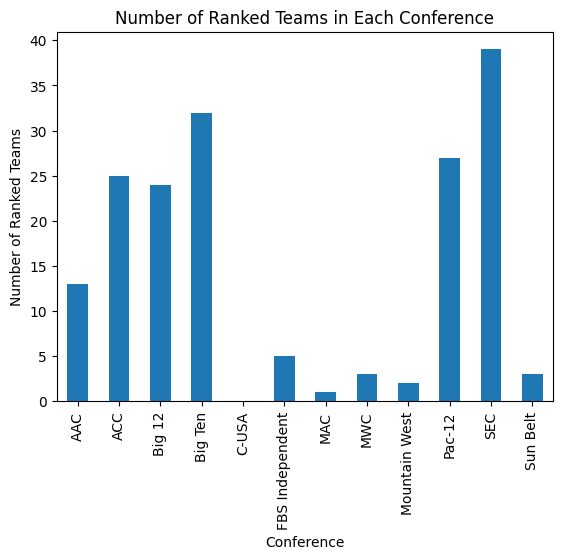

In [248]:
conference_ranked_counts = df.groupby('conference')['top 25'].sum()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('Conference')
plt.ylabel('Number of Ranked Teams')
plt.title('Number of Ranked Teams in Each Conference')
plt.show()

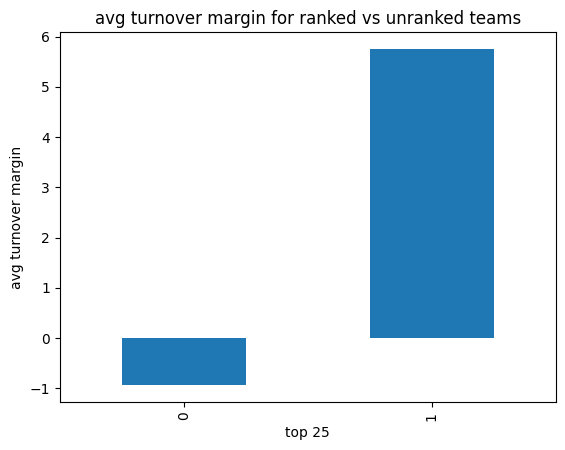

In [249]:
conference_ranked_counts = df.groupby('top 25')['Turnover.Margin'].mean()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('top 25')
plt.ylabel('avg turnover margin')
plt.title('avg turnover margin for ranked vs unranked teams')
plt.show()

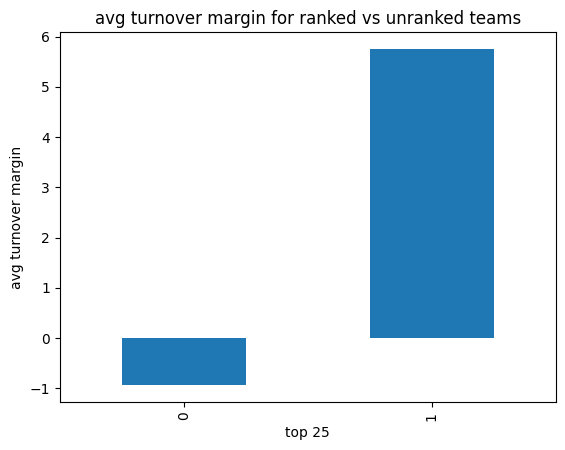

In [250]:
conference_ranked_counts = df.groupby('top 25')['Turnover.Margin'].mean()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('top 25')
plt.ylabel('avg turnover margin')
plt.title('avg turnover margin for ranked vs unranked teams')
plt.show()

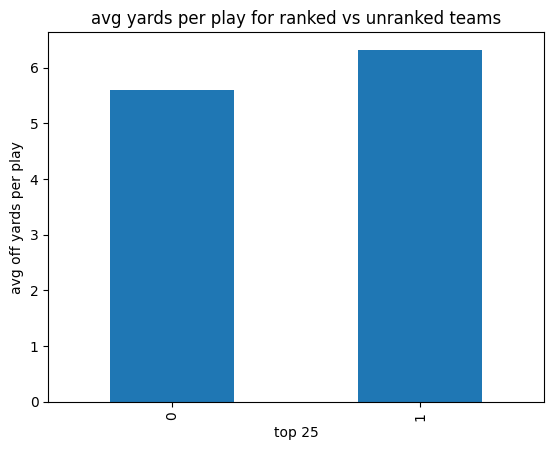

In [251]:
conference_ranked_counts = df.groupby('top 25')['Off.Yards.Play'].mean()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('top 25')
plt.ylabel('avg off yards per play')
plt.title('avg yards per play for ranked vs unranked teams')
plt.show()

In [252]:
one_hot = pd.get_dummies(df['conference'])
one_hot = one_hot.astype('int')
#df = pd.get_dummies(df, columns = ['conference'])
df = df.drop('conference', axis = 1)
df.join(one_hot)

,Team,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,...,Big 12,Big Ten,C-USA,FBS Independent,MAC,MWC,Mountain West,Pac-12,SEC,Sun Belt
0,Akron,12,5,7,88,891,4479,5.03,32,373.3,...,0,0,0,0,1,0,0,0,0,0
1,Alabama,14,12,2,17,1018,6783,6.66,67,484.5,...,0,0,0,0,0,0,0,0,1,0
2,Arizona,14,10,4,25,1139,6491,5.70,55,463.6,...,0,0,0,0,0,0,0,1,0,0
3,Arizona St.,13,10,3,34,975,5750,5.90,54,442.3,...,0,0,0,0,0,0,0,1,0,0
4,Arkansas,13,7,6,60,916,5278,5.76,52,406.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,West Virginia,9,5,4,42,690,3804,5.51,28,422.7,...,1,0,0,0,0,0,0,0,0,0
855,Western Ky.,11,5,6,120,699,3200,4.58,21,290.9,...,0,0,1,0,0,0,0,0,0,0
856,Western Mich.,6,4,2,15,392,2878,7.34,32,479.7,...,0,0,0,0,1,0,0,0,0,0
857,Wisconsin,6,3,3,93,431,2153,5.00,17,358.8,...,0,1,0,0,0,0,0,0,0,0


In [254]:
from sklearn.preprocessing import StandardScaler
no_string_df = df.drop(['Team', 'year'], axis=1)


# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(no_string_df)
# scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
# scaled_df.head()


In [ ]:

# features we are using for the prediction
#test_df = df.drop(['Team','top 25', 'year'],axis=1)

# data we are trying to predict
#result = df['top 25']

In [264]:
# from datetime import time

# # Example time object
# example_time = time(10, 30, 45)  # Represents 10:30:45

# # Convert time to integer (hours * 3600 + minutes * 60 + seconds)
# time_as_int = example_time.hour * 3600 + example_time.minute * 60 + example_time.second

# print(time_as_int)



# for column in no_string_df.columns:
#     column_type = no_string_df[column].dtype
#     if column_type != 'float64' and column_type != 'int64':
#         print(f"Column '{column}' has data type: {column_type}")
#no_string_df['Time.of.Possession']
#no_string_df['Average.Time.of.Possession.per.Game']
for i in no_string_df['Time.of.Possession']:
    x = i.split(':')
    print(int(x[0]) * 60 + int(x[1]))

20951
26678
22873
22391
26557
22505
22363
23305
21527
22630
25818
22012
21692
21764
21575
26062
22397
24483
23458
22768
23177
19096
21956
21127
21548
24313
22831
20423
28692
23112
20671
21616
20396
24518
20529
21791
25531
19368
20645
21518
24738
24955
25371
25847
23982
21070
19630
23492
22835
20966
22226
27575
20712
24506
23106
24357
23578
23003
23614
19847
19869
20625
24132
21196
23286
21457
28354
23659
21835
22024
24135
23183
24382
26378
20819
26209
23617
20770
23677
24038
20210
23845
21181
25126
19213
23886
19292
23588
23203
20478
20236
18784
24539
21138
21983
22735
22000
24875
22749
20456
23053
27268
21357
21235
22787
24502
20688
24034
22672
23306
21907
25570
28260
25600
30230
24485
20551
24566
26824
23748
23224
22123
20602
21733
21543
23456
22375
22456
22674
25699
24084
28743
24217
22367
20240
19489
21751
20828
26018
22944
26515
22730
22645
22417
26314
22838
21381
22743
26571
22704
20409
25068
20236
21081
21770
21687
23871
22994
22561
23473
19876
19429
23673
23337
20675
26101
2760